In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyfits as fits
from numpy import polyfit
from astropy.utils.data import download_file
import pandas as pd
from lmfit import Parameters, minimize

In [133]:
### Download data


### Cepheid table
#cepheid_table = download_file(
#        'http://iopscience.iop.org/0004-637X/699/1/539/suppdata/apj310711t4_ascii.txt', 
#        cache = True)
cepheid_table = 'cepheids_2009.txt'
cepheids = pd.read_csv(cepheid_table,
                       delim_whitespace = True,
                       skiprows = [0,1,2,3, 245, 246, 247],
                       names = (['Field', 'RAdeg', 
                                 'DEdeg', 'ID', 
                                 'Period', 'VtoI', 
                                 'F160Wmag', 'e_F160Wmag',
                                 'Offset', 'Bias', 
                                 'IMrms', 'ObyH', 'Flag', 'src']
                               )
                      )

cepheids.loc[:,'Field'] = cepheids.loc[:, 'Field'].map(lambda x: str(x)[:5])
cepheids=cepheids.fillna(value = '-')
### SNe table
#Sne_table = download_file(
#        'http://iopscience.iop.org/0004-637X/699/1/539/suppdata/apj310711t5_ascii.txt',
#        cache = True)
Sne_table = 'sne_2009.txt'
Sne = pd.read_csv(Sne_table, 
                   
                  delim_whitespace=True, 
                  skiprows = [0,1,2,3,4, 11,12,13,14,15, 16, 17,18],
                  names = (['junk','Host', 'junk','Sn1A',
                            'Filters', 'm0_viPlus5a_v',
                            'sigma', 'DeltaMu_0','e_DeltaMu_0'
                            #'mu_0_Best', 'e_mu_0_Best'
                          ])
                 )
Sne.loc[:,'e_DeltaMu_0'] = (Sne.loc[:,'e_DeltaMu_0'].apply(str).str.replace('\(|\)','')).astype('float')
#Sne.loc[:,'e_mu_0_Best'] = (Sne.loc[:,'e_mu_0_Best'].apply(str).str.replace('\(|\)','')).astype('float')
Sne.loc[:, 'Host'] = 'N'+(Sne.loc[:, 'Host']).astype('string')

maser_distance = {'mu':7.2, 'e_mu':0.32} 
maser_distance = pd.DataFrame(data = maser_distance, index = arange(1))

In [135]:
cepheids

,Field,RAdeg,DEdeg,ID,Period,VtoI,F160Wmag,e_F160Wmag,Offset,Bias,IMrms,ObyH,Flag,src
0,N4536,188.57747,2.193860,9491,19.790,1.10,24.20,0.24,0.52,0.06,0.06,8.69,psl,-
1,N4536,188.57760,2.192130,9935,42.810,1.05,23.59,0.19,0.35,0.04,-0.09,8.68,psl,-
2,N4536,188.57383,2.194050,12075,49.700,1.17,23.26,0.22,0.48,0.15,0.02,8.64,psl,-
3,N4536,188.58908,2.221220,3633,23.370,0.82,23.91,0.20,0.57,0.06,0.14,8.75,psl,-
4,N4536,188.57352,2.219870,6827,24.540,0.74,23.86,0.31,0.70,0.28,0.19,8.71,psl,-
5,N4536,188.57237,2.216330,5630,55.240,1.03,22.55,0.19,0.10,0.05,-0.09,8.72,psl,-
6,N4536,188.58741,2.202540,3571,20.980,0.78,24.02,0.39,0.95,0.29,0.07,8.89,psl,-
7,N4536,188.58842,2.204110,2692,31.590,1.09,23.71,0.20,0.57,0.20,-0.04,8.90,psl,-
8,N4536,188.59047,2.200050,6914,34.630,1.22,22.72,0.22,0.37,0.13,-0.03,8.92,rej,psl
9,N4536,188.59103,2.202740,4786,37.450,0.93,23.67,0.22,0.46,0.13,-0.03,8.93,psl,-


In [102]:
Sne

,junk,Host,junk,Sn1A,Filters,m0_viPlus5a_v,sigma,DeltaMu_0,e_DeltaMu_0
0,SN,N4536,SN,1981B,UBVR,15.156,0.145,1.145,0.0845
1,SN,N4639,SN,1990N,UBVRI,16.059,0.111,2.185,0.0963
2,SN,N3982,SN,1998aq,UBVRI,15.976,0.091,2.473,0.1010
3,SN,N3370,SN,1994ae,UBVRI,16.578,0.102,2.831,0.0771
4,SN,N3021,SN,1995al,UBVRI,16.726,0.113,2.914,0.1010
5,SN,N1309,SN,2002fk,BVRI,16.806,0.103,3.261,0.0861


In [137]:



class CosmoModel(object):
    def __init__(self, cepheids, Sne):
        
        self.cepheids = cepheids
        self.Sne = Sne
        self.fields = ['N4258', 'N3536', 'N3982', 'N3370', 'N3021', 'N1308']
        
        
        ####Cuts
        self.cepheids = self.cepheids.loc[self.cepheids.Flag != 'rej',:]
        self.cepheids = self.cepheids.loc[self.cepheids.Flag !='rej,low',:]
        self.cepheids = self.cepheids.loc[self.cepheids.Flag !='low',:]
        self.cepheids = self.cepheids.loc[self.cepheids.Field not in self.fields, :]
        #self.cepheids = self.cepheids.loc[(5.297 < self.cepheids.Period) & (self.cepheids.Period < 203.3), :]
        #self.cepheids = self.cepheids.loc[self.cepheids.IMrms < 5,:]
        #self.cepheids = self.cepheids.loc[self.cepheids.Field != 'n4536',:]
        #self.cepheids = self.cepheids.loc[self.cepheids.Field != 'n3021',:]

        self.params = Parameters()
        self.params.add('z_p_n4258', value = 25.5)
        self.params.add('b', value = -3, vary = True)
        self.params.add('Z', value = 0, vary = True)
        self.params.add('a_nu', value = 0.47)
        for field in self.fields:
                self.params.add('dmu_'+field, value = 0)
        self.params['dmu_N4258'].vary = False
        self.params['dmu_N4258'].value = 0
        self.params.add('m04258', value = 30)
        self.params.add('m04258bias', value = 0, vary = False)
        self.params.add('mu_geometric', value = 7.2)
        self.params.add('R', value = 0.411, vary = False)
        self.params.add('Q', value = 0, vary = False)
    def Fitted_Mag(self, cepheids, **params):
        cepheids.loc[:,'FittedMag'] = (params['z_p_n4258'] 
                        + params['b'] * log10(cepheids.Period) 
                        + params['Z'] * (cepheids.ObyH - mean(cepheids.loc[cepheids.Field == 'N4258', 'ObyH'])) 
                        + params['R'] * cepheids.VtoI
                        + params['Q'] * cepheids.Bias
                       )
        for field in (self.fields):
            cepheids.loc[cepheids.Field == field,'FittedMag'] = (cepheids.loc[cepheids.Field == field, 'FittedMag'] 
                                                                 + params['dmu_'+field])
        return cepheids
    
    def Fitted_Sne(self, Sne, **params):

        Sne.loc[:, 'fitted_abs_mag'] = params['m04258'] + params['m04258bias']
        for field in self.fields:
            Sne.loc[Sne.Host == field, 'fitted_abs_mag'] += params['dmu_'+field]
        return Sne
    
    def ceph_residual(self, cepheids, **params):
        cepheids.loc[:,:] = self.Fitted_Mag(cepheids, **params)
        result = (self.cepheids.F160Wmag-cepheids.FittedMag)/self.cepheids.e_F160Wmag
        return result
    
    def Sne_residual(self, Sne, **params):
        Sne.loc[:,:] = self.Fitted_Sne(Sne, **params)
        result = (self.Sne.m0_viPlus5a_v - 5 * 0.698 - self.Sne.fitted_abs_mag)/self.Sne['sigma']
        return result

    def priors(self, params):
        ### A_nu
        result = [(params['a_nu'] - 0.698)/0.00225]
        result+=[(params['mu_geometric'] - 7.2)/0.32]
        return array(result)
    
    def residual(self, params):
        Sne_result = self.Sne_residual(self.Sne, **params)
        ceph_result = self.ceph_residual(self.cepheids, **params)
        prior_result = self.priors(params)
        result = concatenate((Sne_result, ceph_result, prior_result))
        return result
    
    def __call__(self):
        out = minimize(self.residual, 
                       self.params
                      #method = 'cg')
                       )
        self.H0 = 10**(out.params['a_nu'].value + 5 + 
                       0.2 * (out.params['m04258'].value - 5*log10(out.params['mu_geometric'].value) - 25))
        return out


In [138]:
model = CosmoModel(cepheids, Sne)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [119]:
result = model()

model.H0

IndexingError: Unalignable boolean Series key provided

In [147]:
print result.chisqr
print model.cepheids.shape
print result.redchi

441.000942556
(444, 14)
1.00227486945


In [148]:
percent_error = {}
for key in result.params.keys():
    if result.params[key].value != 0:
        percent_error[key] = result.params[key].stderr/result.params[key].value * 100
    else:
        percent_error[key] = 0
print percent_error['a_nu'], percent_error['m04258'], percent_error['mu_geometric']

0.322716014275 0.525317987935 4.44949684551


In [149]:
features = ['Period', 'VtoI', 'F160Wmag', 'Bias', 'ObyH']

averages = dict((el, [] ) for el in features)
averages['ddmu'] = []
averages = pd.DataFrame(averages)#, index = arange(1) )
#print averages
count = 1
for field in model.fields:
    if field != 'n4258':
        subframe = model.cepheids.loc[model.cepheids.Field == field, features]
        dmuR11 = Sne.loc[Sne.Host == field, 'DeltaMu_0'].values
        dmuMe = result.params['dmu_'+field]
        #print field, count, dmuR11 - dmuMe
        #subframe.loc[:,'d_dmu'] = [dmuR11 - dmuMe]*subframe.loc[:,'Period'].values.size
        meandict = subframe.mean().to_dict()
        meandict['ddmu'] = dmuR11 - dmuMe
        #print count, meandict
        meanframe = pd.DataFrame(meandict, index = [field])
        #if count == 3: print meanframe 
        count = count + 1
        averages= averages.append(meanframe)
    
#averages = averages.loc[1:, :]
param1 = []
param2 = []
#for key in field_averages.keys():
#    param1.append(field_averages[key].VtoI)
#    params2.append(field_averages[])
averages.corr()


,Bias,F160Wmag,ObyH,Period,VtoI,ddmu
Bias,1.000000,0.285080,0.287914,0.335127,0.031609,0.887568
F160Wmag,0.285080,1.000000,-0.370465,-0.450098,-0.604781,0.434549
ObyH,0.287914,-0.370465,1.000000,0.702866,0.153376,0.350089
Period,0.335127,-0.450098,0.702866,1.000000,0.399448,0.321388
VtoI,0.031609,-0.604781,0.153376,0.399448,1.000000,0.071953
ddmu,0.887568,0.434549,0.350089,0.321388,0.071953,1.000000


In [150]:
features = ['Period', 'VtoI', 'F160Wmag', 'Bias', 'ObyH']

averages = dict((el, [] ) for el in features)
averages['ddmu'] = []
averages = pd.DataFrame(averages)#, index = arange(1) )
#print averages
count = 1
for field in model.fields:
    if field != 'n4258':
        subframe = model.cepheids.loc[model.cepheids.Field == field, features]
        dmuR11 = Sne.loc[Sne.Host == field, 'DeltaMu_0'].values
        dmuMe = result.params['dmu_'+field]
        #print field, count, dmuR11 - dmuMe
        #subframe.loc[:,'d_dmu'] = [dmuR11 - dmuMe]*subframe.loc[:,'Period'].values.size
        meandict = subframe.mean().to_dict()
        meandict['ddmu'] = dmuR11 - dmuMe
        #print count, meandict
        meanframe = pd.DataFrame(meandict, index = [field])
        #if count == 3: print meanframe 
        count = count + 1
        averages= averages.append(meanframe)
    
#averages = averages.loc[1:, :]
param1 = []
param2 = []
#for key in field_averages.keys():
#    param1.append(field_averages[key].VtoI)
#    params2.append(field_averages[])
averages.corr()
averages.F160Wmag

n3370    24.509710
n4536    24.046122
n3982    24.622273
n5584    24.301795
n4639    24.275200
n4038    23.672812
n3021    24.830000
n1309    24.700667
Name: F160Wmag, dtype: float64

In [151]:
print 'Field\tR11 vs Me\tR11 Error\tMy Error'
residual_difference = 0
for key in result.params.keys():
    if key[0:3] == 'dmu':
        if key != 'dmu_n4258':
            dmeR11 = (result.params[key].value 
                      - Sne.loc[Sne['Host']==key[4:],'DeltaMu_0'].values
                      + result.params['m04258bias']
                      )
            residual_difference += dmeR11
            print '%s\t%f\t%f\t%f'%(key[4:], 
                dmeR11, 
                (Sne.loc[Sne['Host']==key[4:], 'e_DeltaMu_0'].values),
                result.params[key].stderr
                               )
print 'mean offset is', residual_difference[0]/8

Field	R11 vs Me	R11 Error	My Error
n3370	-0.116370	0.028400	0.045650
n4536	-0.014716	0.040400	0.043332
n3982	-0.158440	0.046000	0.058631
n5584	-0.148577	0.040100	0.043078
n4639	-0.107279	0.063000	0.058631
n4038	-0.173931	0.056700	0.068467
n3021	-0.263537	0.087000	0.075594
n1309	-0.149434	0.049100	0.056471
mean offset is -0.141535705221


In [152]:
print 'param \t \t value \t \t error \t \t % error'
for key in result.params.keys():
    if len(key)< 8: 
        disp_key = '%s\t'%key
    else:
        disp_key = key
    if result.params[key].value != 0:
        print '%s \t %f \t %f \t %f'%(disp_key, 
                                   result.params[key].value, 
                                   result.params[key].stderr, 
                                   abs(result.params[key].stderr/result.params[key].value)*100
                                  )

H_0_error = model.H0 * sqrt((result.params['a_nu'].stderr * log(10))**2 
                            + (log(10)/5 *result.params['m04258'].stderr )**2
                            + (result.params['mu_geometric'].stderr/result.params['mu_geometric'].value)**2)

H_0_frac_error = H_0_error/model.H0
print '%s \t %f \t %f \t %f'%('H_0      ',model.H0,H_0_error , H_0_frac_error)

param 	 	 value 	 	 error 	 	 % error
z_p_n4258 	 26.245499 	 0.089208 	 0.339897
b	 	 -2.961335 	 0.060161 	 2.031559
Z	 	 -0.240236 	 0.093091 	 38.749810
a_nu	 	 0.698000 	 0.002253 	 0.322716
dmu_n3370 	 2.718630 	 0.045650 	 1.679171
dmu_n4536 	 1.552284 	 0.043332 	 2.791490
dmu_n3982 	 2.316560 	 0.058631 	 2.530930
dmu_n5584 	 2.312423 	 0.043078 	 1.862885
dmu_n4639 	 2.275721 	 0.058631 	 2.576381
dmu_n4038 	 2.222069 	 0.068467 	 3.081241
dmu_n3021 	 2.874463 	 0.075594 	 2.629838
dmu_n1309 	 3.126566 	 0.056471 	 1.806178
m04258	 	 10.249976 	 0.053845 	 0.525318
mu_geometric 	 7.200000 	 0.320364 	 4.449497
R	 	 0.411000 	 0.000000 	 0.000000
H_0       	 77.743250 	 3.980554 	 0.051201


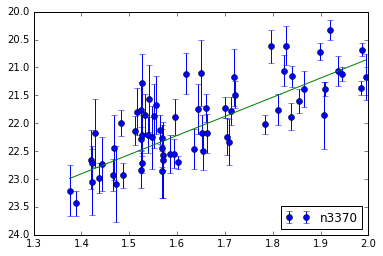

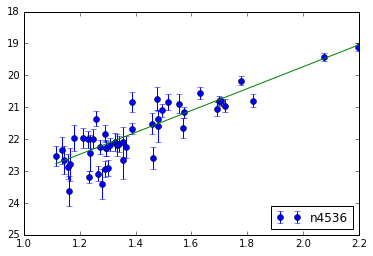

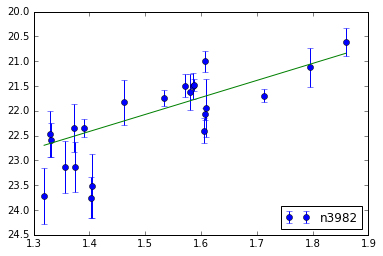

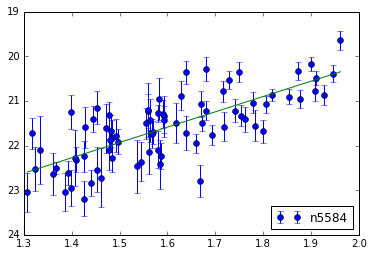

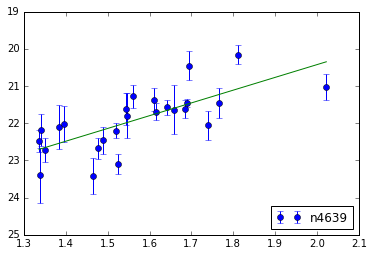

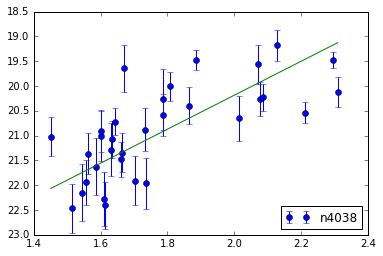

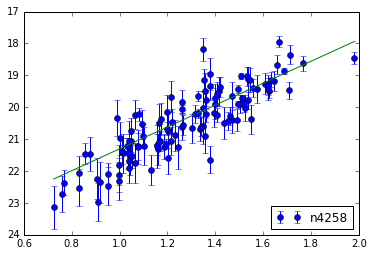

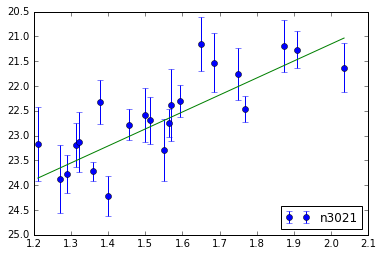

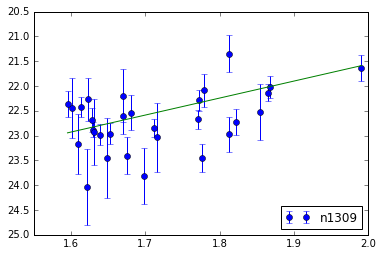

In [142]:
fields = set(model.cepheids.Field)
for i, field in enumerate(fields):
    figure()
    x = log10(model.cepheids.loc[model.cepheids.Field == field, 'Period'])
    #result.params['b'].value * log10(model.cepheids.loc[model.cepheids.Field == field, 'Period'].values)
    y = (model.cepheids.loc[model.cepheids.Field ==field, 'F160Wmag'].values 
         -result.params['R'] * model.cepheids.loc[model.cepheids.Field == field, 'VtoI']
         -result.params['Q'] * model.cepheids.loc[model.cepheids.Field == field, 'Bias']
        )
    yerr = model.cepheids.loc[model.cepheids.Field ==field, 'e_F160Wmag'].values
                                    
    errorbar(x , y , yerr= yerr, label = field, fmt = 'o')
    legend(loc = 4)
    x = array([min(x), max(x)])
    plot(x, result.params['b'] * x + result.params['z_p_n4258'] + result.params['dmu_%s'%field])
    gca().invert_yaxis()
    #xlim(0.4, 2.5)
    #ylim(20,30)
    
    

In [143]:
result.params

Parameters([('z_p_n4258',
             <Parameter 'z_p_n4258', value=24.734021670243205 +/- 0.151, bounds=[-inf:inf]>),
            ('b',
             <Parameter 'b', value=-3.4302204929856859 +/- 0.102, bounds=[-inf:inf]>),
            ('Z',
             <Parameter 'Z', value=-0.063277278486416372 +/- 0.157, bounds=[-inf:inf]>),
            ('a_nu',
             <Parameter 'a_nu', value=0.69799999999999995 +/- 0.0038, bounds=[-inf:inf]>),
            ('dmu_n3370',
             <Parameter 'dmu_n3370', value=2.9745238737635256 +/- 0.0771, bounds=[-inf:inf]>),
            ('dmu_n4536',
             <Parameter 'dmu_n4536', value=1.8574939379404425 +/- 0.0732, bounds=[-inf:inf]>),
            ('dmu_n3982',
             <Parameter 'dmu_n3982', value=2.4851133796505072 +/- 0.099, bounds=[-inf:inf]>),
            ('dmu_n5584',
             <Parameter 'dmu_n5584', value=2.3425973075507303 +/- 0.0727, bounds=[-inf:inf]>),
            ('dmu_n4639',
             <Parameter 'dmu_n4639', value=2.55

In [121]:
set(cepheids.Flag)

{'-', 'low', 'rej', 'rej,low'}

In [122]:
print model.cepheids.loc[:,'Period'].min() ,model.cepheids.loc[:,'Period'].max()

5.297 203.3


(444, 14)

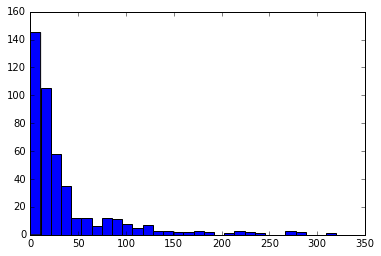

In [123]:
hist(model.cepheids.IMrms, bins = 30);

model.cepheids.shape